# Movilidad y características de comunas


In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
matplotlib.style.use("fivethirtyeight")

## Load Data

In [2]:
prod_33 = "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto33/"
mobility = pd.read_csv(prod_33 + "IndiceDeMovilidad.csv")
mobility["Fecha"] = pd.to_datetime(mobility.Fecha, format="%Y-%m-%d")
mobility['lagged_Fecha'] = mobility['Fecha'] - pd.Timedelta("8d")

print("Fecha min: ", mobility.Fecha.min(), " fecha max: ", mobility.Fecha.max())
mobility.columns

Fecha min:  2020-02-26 00:00:00  fecha max:  2020-06-14 00:00:00


Index(['Region', 'Codigo region', 'Comuna', 'Codigo comuna', 'Superficie_km2',
       'Poblacion', 'IM_interno', 'IM_externo', 'IM', 'Fecha', 'lagged_Fecha'],
      dtype='object')

### Data fechas cuarentena

In [4]:
path_cuarentena = "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto29/Cuarentenas-Totales.csv"

df_cuarentena = pd.read_csv(path_cuarentena)

df_cuarentena["fecha_inicio"] = pd.to_datetime(df_cuarentena['Fecha de Inicio'], format="%Y-%m-%d %H:%M:%S").dt.date
df_cuarentena["fecha_termino"] = pd.to_datetime(df_cuarentena['Fecha de Término'], format="%Y-%m-%d %H:%M:%S").dt.date

df_cuarentena.head(2)

,ID,Nombre,Estado,Alcance,Fecha de Inicio,Fecha de Término,Código CUT Comuna,Detalle,Superficie en m2,Perímetro en m,fecha_inicio,fecha_termino
0,1,Arica,Histórica,Área Urbana Completa,2020-04-16 22:00:00,2020-05-15 22:00:00,15101,Corresponde al Radio Urbano de la Ciudad de Ar...,2.805042e+07,48722.300013,2020-04-16,2020-05-15
1,2,Santiago Norte,Histórica,Sector Específico,2020-04-13 05:00:00,2020-05-05 22:00:00,13101,Corresponde a la extensión de la cuarentena en...,1.993922e+07,21599.351343,2020-04-13,2020-05-05


In [5]:
df_list = []
for i, row in df_cuarentena.iterrows():
    comuna = row['Código CUT Comuna']
    fecha_ini = row['fecha_inicio']
    fecha_end = row['fecha_termino']
    fechas = pd.date_range(start=fecha_ini, end=fecha_end)
    df_aux = pd.DataFrame(fechas)
    df_aux['Codigo comuna'] = comuna
    df_list.append(df_aux)
df_fechas = pd.concat(df_list)
df_fechas.drop_duplicates(inplace=True)
df_fechas.rename(columns={0: 'Fecha'}, inplace=True)
df_fechas['cuarentena'] = 1

mobility = mobility.merge(df_fechas, how='left', on=['Codigo comuna', 'Fecha'])
mobility['cuarentena'] = mobility['cuarentena'].fillna(0)

### Ingresos

Estimación para áreas pequeñas (SAE) 2017

In [6]:
min_desarrollo = "http://observatorio.ministeriodesarrollosocial.gob.cl/documentos/"


ingresos = (pd.read_excel(min_desarrollo + 
    "PLANILLA_Estimaciones_comunales_tasa_pobreza_por_ingresos_multidimensional_2017.xlsx",
                         skiprows=2)
            .rename(columns={"Código": "Codigo comuna"}))

ingresos.head(2)

,Codigo comuna,Región,Nombre comuna,Número de personas en situación de pobreza por ingresos,Porcentaje de personas en situación de pobreza por ingresos 2017,Límite inferior,Límite superior,Metodología de Estimación
0,1101,I de Tarapacá,Iquique,7928,0.043836,0.036953,0.051435,SAE
1,1107,I de Tarapacá,Alto Hospicio,9847,0.077555,0.068831,0.086089,SAE


### Merge

In [7]:
mob_cod_comuna = set(mobility['Codigo comuna'].unique())
ingresos_cod_comuna = set(ingresos['Codigo comuna'].unique())
assert len(mob_cod_comuna - ingresos_cod_comuna) < 2 

df = pd.merge(mobility, ingresos, how='left', on='Codigo comuna')
df['density'] = df['Poblacion'] / df['Superficie_km2']


## Análisis


### Comparando la evolución de movilidad en el tiempo

El `IM_interno` indica los cambios de antena per capita dentro de una comuna. El `IM_externo` rescata los cambios de antena per capita al salir de la comuna.

Veamos el caso de Maipú. La movilidad es alta hasta mediados de marzo y luego baja, pero comienza a subir levemente hasta mediados de mayo. La cuarentena que comienza en esas fechas baja la movilidad considerablemente.


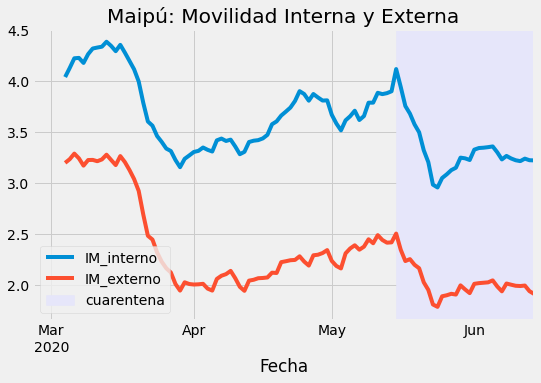

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
codigo_comuna = 13119 #Maipú
comuna = df[df['Codigo comuna'] == codigo_comuna][['Comuna', 'Fecha', 'IM_interno', 'IM_externo', 'IM']]

(comuna.set_index('Fecha')[['IM_interno', 'IM_externo']]
     .rolling(8).mean().plot(ax=ax))
ax.set_title(f"{comuna['Comuna'].iloc[0]}: Movilidad Interna y Externa")

#Fechas de cuarentena:
# Podría haber más de una fila acá si hay más de una cuarentena para esa comuna
cuarentena_com = df_cuarentena[df_cuarentena['Código CUT Comuna'] == 13119]
inicio_cuarentena, fin_cuarentena = cuarentena_com['fecha_inicio'].iloc[0], cuarentena_com['fecha_termino'].iloc[0]
ax.axvspan(pd.to_datetime(inicio_cuarentena), pd.to_datetime(fin_cuarentena), 
           label="cuarentena", color="lavender", alpha=1.)
ax.legend(loc='lower left')

Puesto que los niveles base de cada comuna pueden ser diferentes (la gente de una comuna se mueve más o la relación entre la densidad de antenas y densidad población es diferente), normalizamos el periodo inicial a 1. De esta manera, un 0.7, por ejemplo, significa que la movilidad en ese día está a un 70% de la movilidad del periodo inicial.

La base de datos de movilidad comienza a finales de febrero, por lo que podemos asumir que esas primeras dos semanas representan un periodo relativamente normal para una comuna.

Abajo comparamos la series de tiempo de Las Condes con la Granja y Las Condes con Puente Alto.

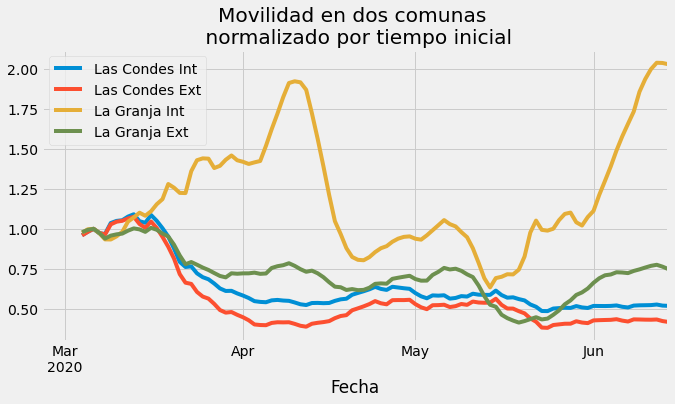

In [9]:
def comparar_dos_comunas(nom_comuna1: str, nom_comuna2: str, df_=df):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    comuna1 = (df_[df_['Comuna'] == nom_comuna1].set_index('Fecha')
     ['IM_interno'].rolling(8).mean())

    (comuna1 / comuna1[9]).plot(ax=ax, label=f"{nom_comuna1} Int")

    comuna1 = (df_[df_['Comuna'] == nom_comuna1].set_index('Fecha')
     ['IM_externo'].rolling(8).mean())
    (comuna1 / comuna1[9]).plot(ax=ax, label=f"{nom_comuna1} Ext")

    comuna2 = (df_[df_['Comuna'] == nom_comuna2].set_index('Fecha')
     ['IM_interno'].rolling(8).mean())
    (comuna2 / comuna2[9]).plot(ax=ax, label=f"{nom_comuna2} Int")

    comuna2 = (df_[df_['Comuna'] == nom_comuna2].set_index('Fecha')
     ['IM_externo'].rolling(8).mean())
    (comuna2 / comuna2[9]).plot(ax=ax, label=f"{nom_comuna2} Ext")
    ax.legend()
    ax.set_title("Movilidad en dos comunas \n normalizado por tiempo inicial");
    
    return fig, ax

comparar_dos_comunas('Las Condes', 'La Granja');

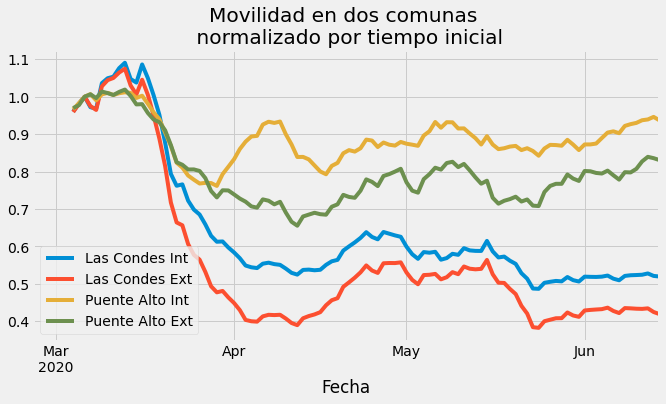

In [69]:
comparar_dos_comunas('Las Condes', 'Puente Alto');

### Scatter plots

+ `cambio_movilidad`: la diferencia % entre la movilidad de la primera mitad y la movilidad de la segunda mitad
+ `delta_int_ext`: en la segunda parte, la diferencia % promedio entre la movilidad interna y la externa

In [70]:
def perc_diff(x, y):
    return 2*(x - y)/(x+y)

def get_mobility_change(comuna_mob):
    n_half = np.ceil(len(comuna_mob) / 2.).astype('int')
    if n_half > 4:
        second_half = np.mean(comuna_mob.values[n_half:])
        first_half = np.mean(comuna_mob.values[0:n_half])
        return perc_diff(second_half, first_half)
    else:
        return np.nan

def get_delta_int_ext(comuna):
    n_half = np.ceil(len(comuna) / 2.).astype('int')
    if n_half > 4:
        mob_int = np.mean(comuna['IM_interno'].values[n_half:])
        mob_ext = np.mean(comuna['IM_externo'].values[n_half:])
        return perc_diff(mob_int, mob_ext)
    else:
        return np.nan

def create_changes_df(df_):
    mobility_change = (df_.groupby("Codigo comuna")
                       ['IM_interno'].apply(get_mobility_change))
    mobility_change.name = 'mobility_change'
    delta_int_ext = (df_.groupby("Codigo comuna")
                       .apply(get_delta_int_ext))
    delta_int_ext.name = 'delta_int_ext'

    porc_pobreza = (df_.groupby('Codigo comuna')
        ['Porcentaje de personas en situación de pobreza por ingresos 2017']
                   .mean())
    porc_pobreza.name = "porc_pobreza"

    changes = pd.concat([mobility_change, delta_int_ext,
                        porc_pobreza], axis=1)
    return changes

changes_country = create_changes_df(df)

/usr/local/anaconda3/envs/spike_basicoV6/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


Text(0.5, 1.0, 'Comunas en Chile \n % de cambio de movilidad vs porc pobreza')

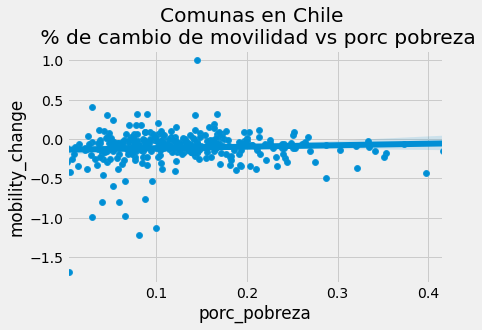

In [73]:
ax = sns.scatterplot(y="mobility_change", x="porc_pobreza", 
                     data=changes_country)
ax = sns.regplot(y="mobility_change", x="porc_pobreza", 
                     data=changes_country)
ax.set_title("Comunas en Chile \n % de cambio de movilidad vs porc pobreza")

Text(0.5, 1.0, 'Comunas en Chile \n % de diff entre movilidad externa e interna vs porc pobreza')

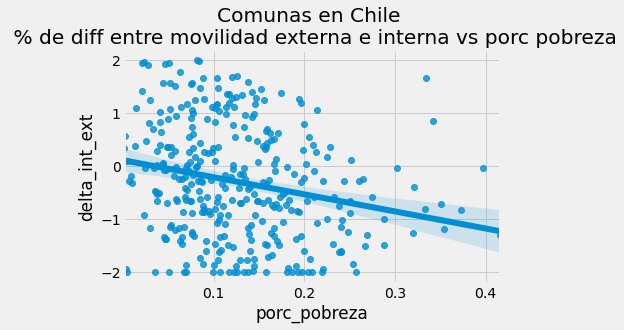

In [75]:
ax = sns.regplot(y="delta_int_ext", x="porc_pobreza",
                     data=changes_country)
ax.set_title("Comunas en Chile \n % de diff entre movilidad externa e interna vs porc pobreza")

In [76]:
metropolitana = df.query("Region == 'Metropolitana de Santiago' ")

changes_metropolitana = create_changes_df(metropolitana)

/usr/local/anaconda3/envs/spike_basicoV6/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


Text(0.5, 1.0, 'Comunas en RM \n % de cambio de movilidad vs porc pobreza')

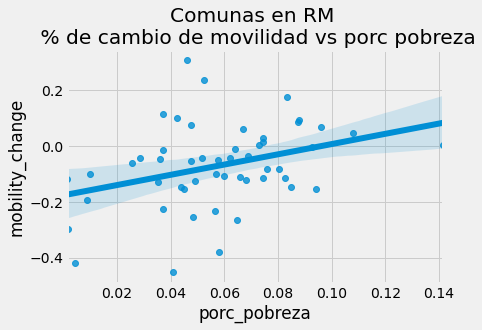

In [77]:
type_ = "regresion"
if type_ == "regression":
    plot_function = sns.scatterplot
else:
    plot_function = sns.regplot
    
ax = plot_function(x="porc_pobreza", y="mobility_change", 
                     data=changes_metropolitana)
ax.set_title("Comunas en RM \n % de cambio de movilidad vs porc pobreza")

Text(0.5, 1.0, 'Comunas en RM \n % de diff entre movilidad externa e interna vs porc pobreza')

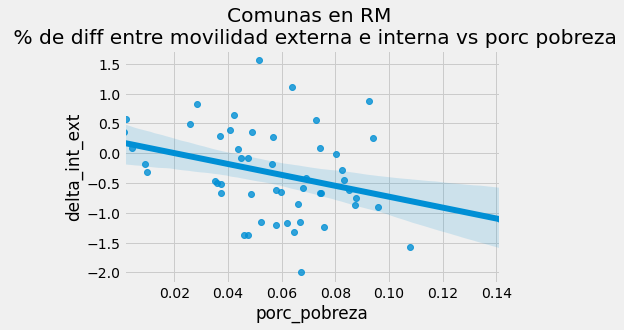

In [78]:
ax = plot_function(y="delta_int_ext", x="porc_pobreza",
                     data=changes_metropolitana)
ax.set_title("Comunas en RM \n % de diff entre movilidad externa e interna vs porc pobreza")

Acá algunos comentarios de estos plots de arriba!!!

## Efecto de cuarentena

Esperamos que la movilidad de todas las comunas bajen con la cuarentena.
Nuestra pregunta es si este cambio depende del porcentaje de pobreza de la comuna.

Vamos a tomar los primeros 10 días como el promedio de movilidad "normal" de una comuna y lo compararemos con la movilidad promedio durante los tiempos de cuarentena

Timestamp('2020-03-07 00:00:00')

In [35]:
corte_periodo_inicial = df.Fecha.min() + pd.Timedelta("10d")
columnas_comuna = ['Comuna', 'Codigo comuna']
cols_relevantes = ['Porcentaje de personas en situación de pobreza por ingresos 2017',
                  'IM_interno', 'IM_externo']

df_inicial = (df[df.Fecha < corte_periodo_inicial].groupby(columnas_comuna)
                   [cols_relevantes].median()
             .rename(columns={
                 'Porcentaje de personas en situación de pobreza por ingresos 2017':
                             'porc_pobreza',
                  'IM_interno': 'IM_interno_inicial',
             'IM_externo': 'IM_externo_inicial'}))

df_cuarentena = (df[df.cuarentena == 1].groupby(columnas_comuna)
                   ['IM_interno', 'IM_externo'].median()
                .rename(columns={'IM_interno': 'IM_interno_cuarentena',
                  'IM_externo': 'IM_externo_cuarentena'}))


df_delta = pd.merge(df_inicial, df_cuarentena, how='inner',
                    left_index=True, right_index=True).reset_index()

def delta_perc(x_post, x_pre):
    return 2*(x_post - x_pre)/(x_post + x_pre)
for tipo_mov in ['interno', 'externo']:
    #Un número negativo significa que se redujo la movilidad
    df_delta[f'perc_change_IM_{tipo_mov}'] = delta_perc(
                                     df_delta[f'IM_{tipo_mov}_cuarentena'],
                                     df_delta[f'IM_{tipo_mov}_inicial'])

df_delta.columns

/usr/local/anaconda3/envs/spike_basicoV6/lib/python3.6/site-packages/ipykernel/__main__.py:15: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


Index(['Comuna', 'Codigo comuna', 'porc_pobreza', 'IM_interno_inicial',
       'IM_externo_inicial', 'IM_interno_cuarentena', 'IM_externo_cuarentena',
       'perc_change_IM_interno', 'perc_change_IM_externo'],
      dtype='object')

(-0.03, 0.27)

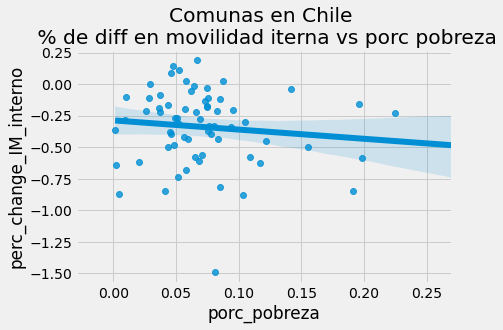

In [46]:
ax = sns.regplot(y="perc_change_IM_interno", x="porc_pobreza",
                     data=df_delta)
ax.set_title("Comunas en Chile \n % de diff en movilidad iterna vs porc pobreza")
ax.set_xlim(-0.03, 0.27)

(-0.03, 0.37)

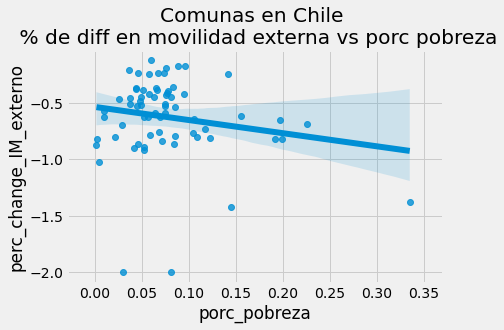

In [49]:
ax = sns.regplot(y="perc_change_IM_externo", x="porc_pobreza",
                     data=df_delta)
ax.set_title("Comunas en Chile \n % de diff en movilidad externa vs porc pobreza")
ax.set_xlim(-0.03, 0.37)

In [55]:
df_delta_metrop['Codigo comuna'].nunique()

43

Un número negativo en `perc_change_IM` significa que se **redujo** la movilidad durante la cuarentena. Por ejemplo, un -0.5 significa que se redujo en un 50% la movilidad de la comuna durante la cuarentena (en comparación con los primeros diez días de la muestra)

Para las comunas de todo Chile que han tenido cuarentena (68 de 346), vemos que no hay una relación clara y, si hay algo, es una pequeña correlación negativa: las comunas más pobres tenderían a bajar más la movilidad.

Si consideramos solamente las columnas de la región metropolitana (43 de esas 68), vemos que esta relación se vuelve positiva y más clara. En este caso, a mayor porcentaje de pobreza hay menor cambio en movilidad. 

Un 47% (20 comunas) tiene menos de 20% de reducción de movilidad y un 14% (6 comunas) registra un aumento de movilidad.

In [30]:
codigos_metropolitana = [13123, 13105, 13124, 13111, 13114, 13106, 13103, 13129, 13403,
       13201, 13601, 13101, 13132, 13401, 13119, 13110, 13104, 13113,
       13301, 13404, 13126, 13118, 13130, 13302, 13120, 13131, 13122,
       13502, 13402, 13109, 13116, 13107, 13127, 13102, 13115, 13128,
       13112, 13108, 13501, 13503, 13125, 13203, 13605, 13303, 13604,
       13602, 13117, 13121, 13603, 13505, 13504, 13202]

(-0.03, 0.15)

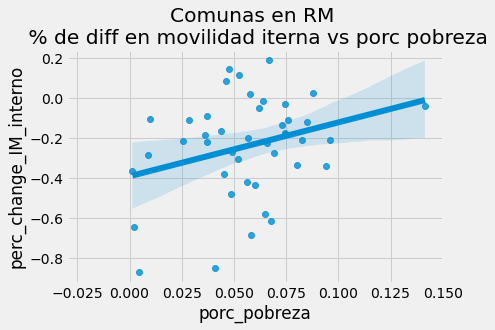

In [56]:
df_delta_metrop = df_delta[df_delta['Codigo comuna'].isin(codigos_metropolitana)]


ax = sns.regplot(y="perc_change_IM_interno", x="porc_pobreza",
                     data=df_delta_metrop, label="holi")
ax.set_title("Comunas en RM \n % de diff en movilidad iterna vs porc pobreza")
ax.set_xlim(-0.03, 0.15)


(-0.03, 0.15)

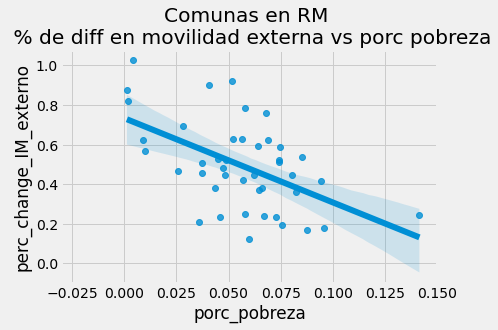

In [42]:

ax = sns.regplot(y="perc_change_IM_externo", x="porc_pobreza",
                     data=df_delta_metrop)
ax.set_title("Comunas en RM \n % de diff en movilidad externa vs porc pobreza")
ax.set_xlim(-0.03, 0.15)

### Una regresión simple

$$ movilidad_t = \alpha_0 + \alpha_1 densidad + \alpha_2 cuarentena + \alpha_3 cuarentena * \%pobreza + \varepsilon $$

¿Qué información nos entrega esta regresión?

+ Controlamos por densidad
+ Nos da un valor "promedio" del efecto de una cuarentena
+ Nos entrega una idea de cómo interactúa la cuarentena con el porcentaje de pobreza de la comuna

(luego interpretar los números)

In [42]:
im_interno_inicial = df_inicial['IM_interno_inicial']


'IM_interno_inicial'

In [51]:
df_inicial.reset_index().dtypes

Comuna                 object
Codigo comuna           int64
porc_pobreza          float64
IM_interno_inicial    float64
IM_externo_inicial    float64
dtype: object

In [55]:
df = pd.merge(df.reset_index(), df_inicial.reset_index(), )

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf


df['perc_pobreza'] = df['Porcentaje de personas en situación de pobreza por ingresos 2017']

df = pd.merge(df, df_inicial['IM_interno_inicial'], on=['Codigo comuna'])

df['IM_interno_norm'] = df['IM_interno'] / df['IM_interno_inicial']
#'IM_interno_norm'?

df_metrop = df.query("Region == 'Metropolitana de Santiago'")

In [62]:
mod = smf.ols(formula='IM_interno_norm ~ density + cuarentena + cuarentena * perc_pobreza - 1',
              data=df)
res = mod.fit()
results_as_html = res.summary().tables[1].as_html()
resultados_chile = pd.read_html(results_as_html, header=0, index_col=0)[0].T
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:        IM_interno_norm   R-squared (uncentered):                     nan
Model:                            OLS   Adj. R-squared (uncentered):                nan
Method:                 Least Squares   F-statistic:                                nan
Date:                Mon, 29 Jun 2020   Prob (F-statistic):                         nan
Time:                        18:46:30   Log-Likelihood:                             nan
No. Observations:               35365   AIC:                                        nan
Df Residuals:                   35361   BIC:                                        nan
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [63]:

mod = smf.ols(formula='IM_interno_norm ~ density + cuarentena + cuarentena : perc_pobreza - 1',
              data=df_metrop)
res = mod.fit()
results_as_html = res.summary().tables[1].as_html()
resultados_metro = pd.read_html(results_as_html, header=0, index_col=0)[0].T
print(res.summary())


                                 OLS Regression Results                                
Dep. Variable:        IM_interno_norm   R-squared (uncentered):                   0.849
Model:                            OLS   Adj. R-squared (uncentered):              0.849
Method:                 Least Squares   F-statistic:                              7870.
Date:                Mon, 29 Jun 2020   Prob (F-statistic):                        0.00
Time:                        18:46:35   Log-Likelihood:                         -2277.7
No. Observations:                5610   AIC:                                      4563.
Df Residuals:                    5606   BIC:                                      4590.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [30]:
resultados_metro


,density,cuarentena,cuarentena:perc_pobreza
coef,0.000200,2.8107,-29.2394
std err,0.000005,0.1500,2.2790
t,36.429000,18.7340,-12.8280
P>|t|,0.000000,0.0000,0.0000
[0.025,0.000000,2.5170,-33.7080
0.975],0.000000,3.1050,-24.7710


In [31]:
resultados_chile

,density,cuarentena,cuarentena:perc_pobreza
coef,0.000200,1.9986,-9.2507
std err,0.000005,0.1060,1.2080
t,44.834000,18.7990,-7.6570
P>|t|,0.000000,0.0000,0.0000
[0.025,0.000000,1.7900,-11.6190
0.975],0.000000,2.2070,-6.8830


Con una densidad promedio (XXX), podemos hacer un plot del efecto de cuarentena predicho para diferentes niveles de porcentaje de pobreza


In [ ]:


cols = ['IM_interno', 'IM_externo', 
        'Porcentaje de personas en situación de pobreza por ingresos 2017',
       'density']
df_grouped = df.groupby(['Codigo comuna', 'Nombre comuna', 'cuarentena'])[cols].mean()
df_new = df_grouped.reset_index()

df_new.set_index(['Codigo comuna', 'Nombre comuna'], inplace=True)

df_antes = (df_new[df_new.cuarentena == 0]
            .rename(columns={'IM_interno': 'IM_interno_s_cuarentena'}))
df_despues = (df_new[df_new.cuarentena == 1]
             .rename(columns={'IM_interno': 'IM_interno_c_cuarentena'}))


df_new_new = df_antes.merge(df_despues, left_index=True, right_index=True)

def delta_perc(x_pre, x_post):
    return 2*(x_post - x_pre)/(x_post + x_pre)
df_new_new['perc_change_IM_interno'] = delta_perc(df_new_new['IM_interno_s_cuarentena'],
                                         df_new_new['IM_interno_c_cuarentena'])

df_new_new = df_new_new.reset_index()
metropolitana_df = df_new_new[df_new_new['Codigo comuna'].isin(codigos_metropolitana)].copy()

for df_ in [df_new_new, metropolitana_df]:
    df_["porc_pobreza"] = df_['Porcentaje de personas en situación de pobreza por ingresos 2017_x']
variable_ingreso = "porc_pobreza"
variable_change = 'perc_change_IM_interno'
#ax = sns.scatterplot(x="change", y="ytotcorh_x", 
#                     data=df_new_new)

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
sns.regplot(x=variable_ingreso, y=variable_change, data=df_new_new, fit_reg=True, ax=axes[0]);
axes[0].set_title("Comunas en Chile \n % de cambio de movilidad por cuarentena vs porc pobreza")

sns.regplot(x=variable_ingreso, y=variable_change, data=metropolitana_df, fit_reg=True, ax=axes[1]);
axes[1].set_title("Comunas en RM \n % de cambio de movilidad por cuarentena vs porc pobreza")

fig.tight_layout()